In [1]:
import os
from glob import glob

import pandas as pd

In [2]:
def extract_miso_forecasts(path):
    """
    Takes a filepath to .xlsx MISO MOM reports and extracts wind and load forecasts.
    Saves data to an Excel file - miso_forecasts.xlsx, and returns the DataFrame.
    """
    excel_files = glob(os.path.join(path, '*.xlsx'))
    full_forecast_df = None
    for file in excel_files:
        df = pd.read_excel(file, sheet_name='MISO', skiprows=4, nrows=17, index_col=0, usecols=range(7))
        
        # get data
        loads = df.loc['Projected Load', :].to_list()
        wind = df.loc['Renewable Forecast', :].to_list()
        
        # make column labels
        load_labels = [f'load_d{d}' for d in range(1, 7)]
        wind_labels = [f'wind_d{d}' for d in range(1, 7)]
        
        # create and append dataframe
        data_dict = {col: val for col, val in zip(load_labels + wind_labels, loads + wind)}
        date = pd.to_datetime(file.split('\\')[-1].split('_')[0])
        forecast_df = pd.DataFrame.from_records(data=data_dict, index=[date])
        if full_forecast_df is None:
            full_forecast_df = forecast_df.copy()
        else:
            full_forecast_df = full_forecast_df.append(forecast_df)
    
    full_forecast_df.sort_index(inplace=True)
    full_forecast_df.to_excel('miso_forecasts.xlsx')
    return full_forecast_df

In [3]:
forecast_df = extract_miso_forecasts('../data/excel/')

In [4]:
historical_df = pd.read_excel('../data/test_your_knowledge/excel/20210204_rfal_HIST.xls', skiprows=4, usecols=range(1, 7))
historical_df.head()

,Market Day,HourEnding,Region,MTLF (MWh),Actual Load (MWh),Footnote
0,01/01/2021,1.0,Central,33325.0,35222.81,NaN
1,01/01/2021,1.0,MISO,66890.0,68692.36,NaN
2,01/01/2021,1.0,North,16367.0,16502.11,NaN
3,01/01/2021,1.0,South,17198.0,16967.44,NaN
4,01/01/2021,2.0,Central,32432.0,34360.54,NaN


In [5]:
historical_miso = historical_df[historical_df['Region'] == 'MISO']

In [6]:
daily_mean_historical = historical_miso.groupby('Market Day').mean()

In [7]:
daily_mean_historical.head()

,HourEnding,MTLF (MWh),Actual Load (MWh),Footnote
Market Day,,,,
01/01/2021,12.5,67657.041667,70077.212917,NaN
01/02/2021,12.5,71066.875000,71279.402917,NaN
01/03/2021,12.5,70403.708333,71883.935417,NaN
01/04/2021,12.5,75716.166667,76214.211250,NaN
01/05/2021,12.5,76593.250000,76091.320417,NaN


In [8]:
daily_mean_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 01/01/2021 to 02/03/2021
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HourEnding         34 non-null     float64
 1   MTLF (MWh)         34 non-null     float64
 2   Actual Load (MWh)  34 non-null     float64
 3   Footnote           0 non-null      float64
dtypes: float64(4)
memory usage: 1.3+ KB


In [9]:
daily_mean_historical.index = pd.to_datetime(daily_mean_historical.index)

In [10]:
forecast_df.head()

,load_d1,load_d2,load_d3,load_d4,load_d5,load_d6,wind_d1,wind_d2,wind_d3,wind_d4,wind_d5,wind_d6
2021-01-23,77528.0,81575.0,82841.0,81974.0,82897.0,83236.0,5373.7,14352.5,6350.8,4666.5,7529.2,14353.6
2021-01-24,83310.0,82300.0,82452.0,84568.0,84231.0,72855.0,15996.5,7030.6,5094.1,7496.4,5232.0,16207.2
2021-01-25,83135.0,84945.0,86705.0,86325.0,73520.0,73509.0,8529.6,4371.5,9566.0,7825.3,15260.2,12907.8
2021-01-26,84898.0,88174.0,86816.0,74929.0,75048.0,80868.0,4179.6,9625.7,7896.6,14690.1,10564.0,4949.9
2021-01-27,89361.0,87024.0,75566.0,75378.0,81915.0,83146.0,9498.3,10986.1,13680.6,7576.2,4346.1,7028.9


We will compare the 1-day forcast with historical values.

In [11]:
forecast_df_shifted_1 = forecast_df.copy()
forecast_df_shifted_1.index = forecast_df.index + pd.Timedelta(days=1)

In [12]:
forecast_df_shifted_1.head()

,load_d1,load_d2,load_d3,load_d4,load_d5,load_d6,wind_d1,wind_d2,wind_d3,wind_d4,wind_d5,wind_d6
2021-01-24,77528.0,81575.0,82841.0,81974.0,82897.0,83236.0,5373.7,14352.5,6350.8,4666.5,7529.2,14353.6
2021-01-25,83310.0,82300.0,82452.0,84568.0,84231.0,72855.0,15996.5,7030.6,5094.1,7496.4,5232.0,16207.2
2021-01-26,83135.0,84945.0,86705.0,86325.0,73520.0,73509.0,8529.6,4371.5,9566.0,7825.3,15260.2,12907.8
2021-01-27,84898.0,88174.0,86816.0,74929.0,75048.0,80868.0,4179.6,9625.7,7896.6,14690.1,10564.0,4949.9
2021-01-28,89361.0,87024.0,75566.0,75378.0,81915.0,83146.0,9498.3,10986.1,13680.6,7576.2,4346.1,7028.9


In [13]:
combined_df = forecast_df_shifted_1.merge(daily_mean_historical, left_index=True, right_index=True)
combined_df.head()

,load_d1,load_d2,load_d3,load_d4,load_d5,load_d6,wind_d1,wind_d2,wind_d3,wind_d4,wind_d5,wind_d6,HourEnding,MTLF (MWh),Actual Load (MWh),Footnote
2021-01-24,77528.0,81575.0,82841.0,81974.0,82897.0,83236.0,5373.7,14352.5,6350.8,4666.5,7529.2,14353.6,12.5,70779.958333,70444.783333,NaN
2021-01-25,83310.0,82300.0,82452.0,84568.0,84231.0,72855.0,15996.5,7030.6,5094.1,7496.4,5232.0,16207.2,12.5,76264.958333,76271.412083,NaN
2021-01-26,83135.0,84945.0,86705.0,86325.0,73520.0,73509.0,8529.6,4371.5,9566.0,7825.3,15260.2,12907.8,12.5,76786.291667,76364.597917,NaN
2021-01-27,84898.0,88174.0,86816.0,74929.0,75048.0,80868.0,4179.6,9625.7,7896.6,14690.1,10564.0,4949.9,12.5,78331.333333,78821.991250,NaN
2021-01-28,89361.0,87024.0,75566.0,75378.0,81915.0,83146.0,9498.3,10986.1,13680.6,7576.2,4346.1,7028.9,12.5,81216.416667,82155.233750,NaN


<AxesSubplot:>

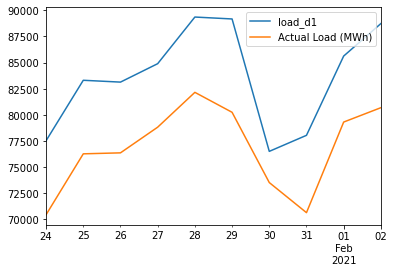

In [14]:
combined_df[['load_d1', 'Actual Load (MWh)']].plot()

It looks like the 1-day predictions are higher than what the actual load is. This could be because the predictions have a built-in buffer to be higher than the real expectation, so that they will be ready to generate more power than they need. To take this further, we would use the timedelta method with the index to shift the forecast df by different numbers of days, and combine these all into one dataframe. Then we could plot the historical load with predictions multiple days out and see how they compare.